### Data visualization and exploration

Selected 5 different classes:
car crash,
door creaking sound with scream,
gunshot scream(created duplicates of same sound to test it later),
yelling

In [1]:
#import all libraries
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

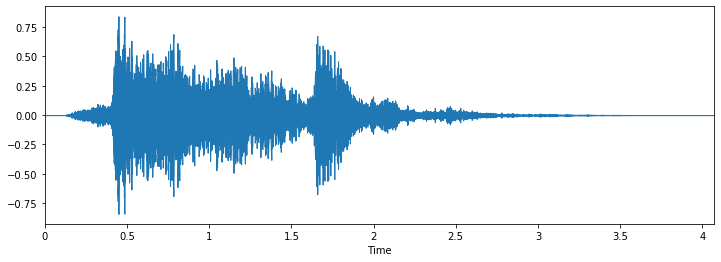

In [2]:
# load and plot the audio file data
#class car crash
filename = r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/fold5/car_crash.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

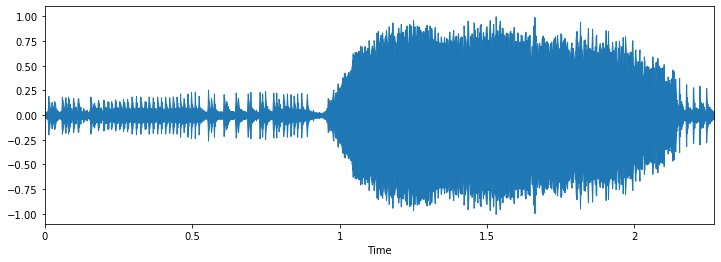

In [3]:
# load and plot the audio file data
#class doorscrm
filename1 = r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/fold5/doorscrm.wav'
plt.figure(figsize=(12,4))
data1,sample_rate1 = librosa.load(filename1)
_ = librosa.display.waveplot(data1,sr=sample_rate1)
ipd.Audio(filename1)

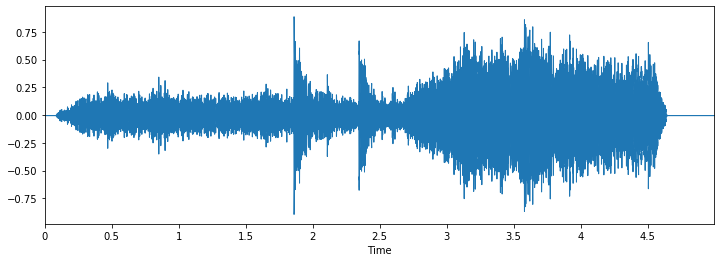

In [4]:
# load and plot the audio file data
#class dummy
filename2 = r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/fold2/dummy.wav'
plt.figure(figsize=(12,4))
data2,sample_rate2 = librosa.load(filename2)
_ = librosa.display.waveplot(data2,sr=sample_rate2)
ipd.Audio(filename2)

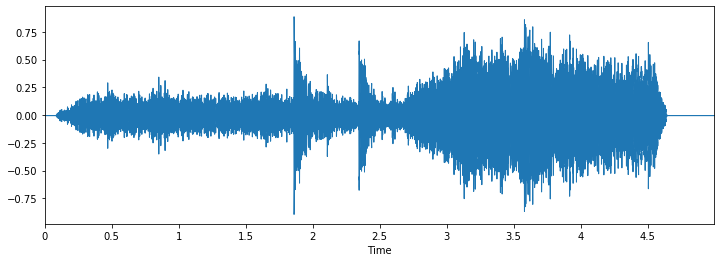

In [5]:
# load and plot the audio file data
#class new
filename3 = r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/fold4/new.wav'
plt.figure(figsize=(12,4))
data3,sample_rate3 = librosa.load(filename3)
_ = librosa.display.waveplot(data3,sr=sample_rate3)
ipd.Audio(filename3)

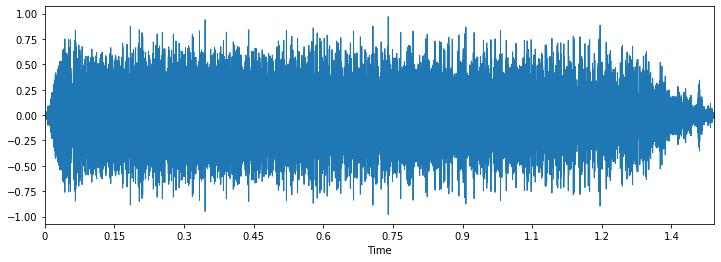

In [6]:
# load and plot the audio file data
#class yelp
filename4 = r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/fold3/yelp.wav'
plt.figure(figsize=(12,4))
data4,sample_rate4 = librosa.load(filename4)
_ = librosa.display.waveplot(data4,sr=sample_rate4)
ipd.Audio(filename4)

### Loading metadata of the dataset

In [7]:
import pandas as pd
metadata = pd.read_csv(r'C:/Users/nikita.ramesh.rao/Desktop/test/test_data.csv')
metadata.head()

slice_file_name       fsID  start  end  salience  fold  classID class_name
0     car_crash.wav  car_crash      0  3.1         1     5        1  car_crash
1    car_crash0.wav  car_crash      0  3.1         1     5        1  car_crash
2    car_crash1.wav  car_crash      0  3.1         1     5        1  car_crash
3   car_crash10.wav  car_crash      0  3.1         1     5        1  car_crash
4  car_crash100.wav  car_crash      0  3.1         1     5        1  car_crash

### Class distributions

In [8]:
print(metadata.class_name.value_counts())

yelp         1203
doorscrm      717
dummy         600
new           410
car_crash     347
Name: class_name, dtype: int64


## Observations

### Audio sample file properties

In [9]:
import pandas as pd
import os
import librosa
import librosa.display

from helpers.wavfilehelper import WavFileHelper
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

### Audio channels

In [10]:
print(audiodf.num_channels.value_counts(normalize=True))

1    0.585902
2    0.414098
Name: num_channels, dtype: float64


### Sample Rate

In [11]:
print(audiodf.sample_rate.value_counts(normalize=True))

22050    0.585902
44100    0.414098
Name: sample_rate, dtype: float64


### Bit_Depth

In [12]:
print(audiodf.bit_depth.value_counts(normalize=True))

16    0.781202
8     0.218798
Name: bit_depth, dtype: float64


## Data preprocessing and Splitting

#### Audio properties that need preprocessing:
Sample rate, audio channels and bit depth
This preprocessing is necessary for consistency across the whole dataset during training

### Preprocessing stage
For much of the preprocessing we will be able to use Librosa's load() function.

We will compare the outputs from Librosa against the default outputs of scipy's wavfile library using a chosen file from the dataset.

#### Sample rate conversion
By default, Librosa’s load function converts the sampling rate to 22.05 KHz which we can use as our comparison level.

In [13]:
import librosa 
from scipy.io import wavfile as wav
import numpy as np

filename = r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/fold5/car_crash.wav'

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate)

Original sample rate: 44100
Librosa sample rate: 22050


### Bit-depth
Librosa’s load function will also normalise the data so it's values range between -1 and 1. This removes the complication of the dataset having a wide range of bit-depths.

In [14]:
print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -31238 to 29820
Librosa audio file min~max range: -0.8393417 to 0.84206676


### Merge audio channels

Librosa will also convert the signal to mono, meaning the number of channels will always be 1.

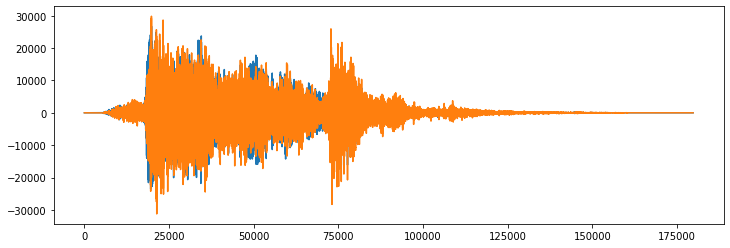

In [15]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

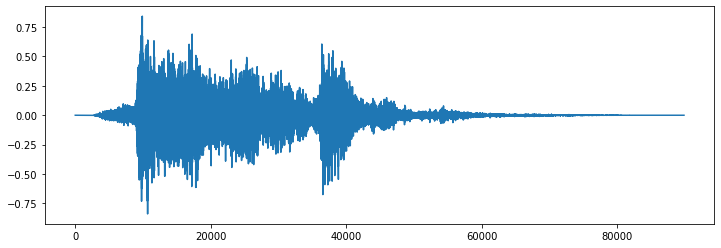

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

### Extract Features
We will extract Mel-Frequency Cepstral Coefficients (MFCC) from the the audio samples.

The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [17]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 176)


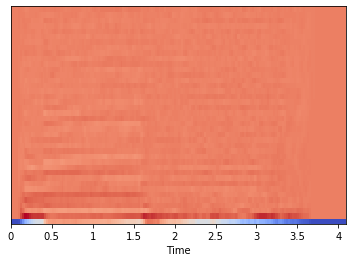

In [18]:
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

### Extracting MFCC's for every file
We will now extract an MFCC for each audio file in the dataset and store it in a Panda Dataframe along with it's classification label.

In [19]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [20]:
#load various imports
import pandas as pd
import os
import librosa

# Set the path to the full dataset 
fulldatasetpath = r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/'

metadata = pd.read_csv(r'C:/Users/nikita.ramesh.rao/Desktop/test/test_data.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class_name"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  3277  files


### Convert the data and labels
We will use sklearn.preprocessing.LabelEncoder to encode the categorical text data into model-understandable numerical data.

In [21]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

Using TensorFlow backend.


### Split the dataset
Here we will use sklearn.model_selection.train_test_split to split the dataset into training and testing sets. The testing set size will be 20% and we will set a random state.

In [22]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

## Model training and evaluation

### Model architecture - MLP

In [23]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [24]:
#Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 


In [25]:
#Display model architecture
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

## Training

In [26]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

start = datetime.now()
#fit and train the model
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test),verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 2621 samples, validate on 656 samples
Epoch 1/100
2621/2621 [==============================] - ETA: 11s - loss: 26.3422 - accuracy: 0.15 - ETA: 0s - loss: 9.3505 - accuracy: 0.5696 - ETA: 0s - loss: 6.1107 - accuracy: 0.67 - ETA: 0s - loss: 4.5855 - accuracy: 0.73 - 0s 132us/step - loss: 4.0548 - accuracy: 0.7528 - val_loss: 1.0882 - val_accuracy: 0.8399
Epoch 2/100
2621/2621 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.90 - ETA: 0s - loss: 1.1727 - accuracy: 0.86 - ETA: 0s - loss: 1.0596 - accuracy: 0.84 - ETA: 0s - loss: 0.9605 - accuracy: 0.84 - 0s 75us/step - loss: 0.9331 - accuracy: 0.8455 - val_loss: 0.2103 - val_accuracy: 0.8720
Epoch 3/100
2621/2621 [==============================] - ETA: 0s - loss: 0.8558 - accuracy: 0.87 - ETA: 0s - loss: 0.6270 - accuracy: 0.85 - ETA: 0s - loss: 0.5302 - accuracy: 0.85 - ETA: 0s - loss: 0.4903 - accuracy: 0.86 - 0s 80us/step - loss: 0.4864 - accuracy: 0.8565 - val_loss: 0.1980 - val_accuracy: 0.8720
Epoch 

2621/2621 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.93 - ETA: 0s - loss: 0.2134 - accuracy: 0.87 - ETA: 0s - loss: 0.2101 - accuracy: 0.87 - ETA: 0s - loss: 0.2132 - accuracy: 0.86 - 0s 79us/step - loss: 0.2119 - accuracy: 0.8722 - val_loss: 0.2019 - val_accuracy: 0.8720
Epoch 27/100
2621/2621 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.78 - ETA: 0s - loss: 0.2170 - accuracy: 0.85 - ETA: 0s - loss: 0.2112 - accuracy: 0.86 - ETA: 0s - loss: 0.2199 - accuracy: 0.86 - 0s 74us/step - loss: 0.2178 - accuracy: 0.8607 - val_loss: 0.1986 - val_accuracy: 0.8720
Epoch 28/100
2621/2621 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.78 - ETA: 0s - loss: 0.2222 - accuracy: 0.86 - ETA: 0s - loss: 0.2120 - accuracy: 0.87 - 0s 60us/step - loss: 0.2164 - accuracy: 0.8646 - val_loss: 0.1982 - val_accuracy: 0.8720
Epoch 29/100
2621/2621 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.81 - ETA: 0s - 

2621/2621 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.81 - ETA: 0s - loss: 0.2148 - accuracy: 0.85 - ETA: 0s - loss: 0.2172 - accuracy: 0.86 - 0s 64us/step - loss: 0.2175 - accuracy: 0.8703 - val_loss: 0.1986 - val_accuracy: 0.8720
Epoch 53/100
2621/2621 [==============================] - ETA: 0s - loss: 0.2382 - accuracy: 0.78 - ETA: 0s - loss: 0.2118 - accuracy: 0.85 - ETA: 0s - loss: 0.2057 - accuracy: 0.87 - 0s 63us/step - loss: 0.2147 - accuracy: 0.8718 - val_loss: 0.1981 - val_accuracy: 0.8720
Epoch 54/100
2621/2621 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.93 - ETA: 0s - loss: 0.2104 - accuracy: 0.87 - ETA: 0s - loss: 0.2128 - accuracy: 0.87 - 0s 65us/step - loss: 0.2160 - accuracy: 0.8722 - val_loss: 0.1981 - val_accuracy: 0.8720
Epoch 55/100
2621/2621 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.87 - ETA: 0s - loss: 0.2518 - accuracy: 0.83 - ETA: 0s - loss: 0.2257 - accuracy: 0.86 - ETA: 0s - 

Epoch 81/100
2621/2621 [==============================] - ETA: 0s - loss: 0.3077 - accuracy: 0.75 - ETA: 0s - loss: 0.2166 - accuracy: 0.87 - ETA: 0s - loss: 0.2186 - accuracy: 0.86 - 0s 62us/step - loss: 0.2122 - accuracy: 0.8752 - val_loss: 0.1990 - val_accuracy: 0.8720
Epoch 82/100
2621/2621 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.84 - ETA: 0s - loss: 0.2131 - accuracy: 0.88 - ETA: 0s - loss: 0.2139 - accuracy: 0.87 - ETA: 0s - loss: 0.2115 - accuracy: 0.87 - 0s 66us/step - loss: 0.2115 - accuracy: 0.8756 - val_loss: 0.1986 - val_accuracy: 0.8720
Epoch 83/100
2621/2621 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.78 - ETA: 0s - loss: 0.2149 - accuracy: 0.87 - ETA: 0s - loss: 0.2052 - accuracy: 0.87 - 0s 66us/step - loss: 0.2115 - accuracy: 0.8756 - val_loss: 0.2001 - val_accuracy: 0.8720
Epoch 84/100
2621/2621 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.81 - ETA: 0s - loss: 0.2042 - accuracy: 0.88

## Test the model

In [27]:
#test model accuracy on training and testing data
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8756200075149536
Testing Accuracy:  0.8719512224197388


In [28]:
#save the model
model.save("C:/Users/nikita.ramesh.rao/Desktop/test/saved_models/model.h5")
print("Saved model to disk")

Saved model to disk


In [29]:
#load the model for predictions on other data
from keras.models import load_model
model = load_model("C:/Users/nikita.ramesh.rao/Desktop/test/saved_models/model.h5")

### Predictions

In [30]:
import librosa 
import numpy as np 

def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    return np.array([mfccsscaled])

In [31]:
def print_prediction(file_name):
    prediction_feature = extract_feature(file_name) 

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

### Validation

#### Test with sample data
Initial sainity check to verify the predictions using a subsection of the sample audio files we explored in the first notebook. We expect the bulk of these to be classified correctly.

In [32]:
filename = r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/fold1/car_crash13.wav'
print_prediction(filename) 

The predicted class is: car_crash 

car_crash 		 :  1.00000000000000000000000000000000
doorscrm 		 :  0.00000000000000000000000000000000
dummy 		 :  0.00000000000000000000000000000000
new 		 :  0.00000000000000000000000000000000
yelp 		 :  0.00000000000000000000000000000000


In [33]:
filename = r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/fold2/doorscrm7.wav'
print_prediction(filename) 

The predicted class is: doorscrm 

car_crash 		 :  0.00000000000000000000000000000042
doorscrm 		 :  1.00000000000000000000000000000000
dummy 		 :  0.00000000000000000000000000000000
new 		 :  0.00000000000000000000000000000085
yelp 		 :  0.00000000000000000000000000000983


In [35]:
filename = r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/fold2/dummy0.wav'
print_prediction(filename) 

The predicted class is: dummy 

car_crash 		 :  0.00002418463554931804537773132324
doorscrm 		 :  0.00003294029011158272624015808105
dummy 		 :  0.59933984279632568359375000000000
new 		 :  0.40053829550743103027343750000000
yelp 		 :  0.00006468096398748457431793212891


In [37]:
filename = r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/fold4/new.wav'
print_prediction(filename) 

The predicted class is: dummy 

car_crash 		 :  0.00002418463554931804537773132324
doorscrm 		 :  0.00003294029011158272624015808105
dummy 		 :  0.59933984279632568359375000000000
new 		 :  0.40053829550743103027343750000000
yelp 		 :  0.00006468096398748457431793212891


In [39]:
filename = r'C:/Users/nikita.ramesh.rao/Desktop/test/sample/fold1/yelp8.wav'
print_prediction(filename) 

The predicted class is: yelp 

car_crash 		 :  0.00000000000000000000000000000000
doorscrm 		 :  0.00000000000000000000000000000000
dummy 		 :  0.00000000000000000000000000000000
new 		 :  0.00000000000000000000000000000000
yelp 		 :  1.00000000000000000000000000000000


## Results
Saving the model and loading the model to print predictions for existing class. Since new and dummy are the same set of audio files it gives the predicted class same for both.

## Other audio
Testing on other audio files that were not part of training or testing

In [41]:
name = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/7383-3-0-0.wav'
print_prediction(name) 

The predicted class is: car_crash 

car_crash 		 :  1.00000000000000000000000000000000
doorscrm 		 :  0.00000000000000000000000000000000
dummy 		 :  0.00000000000000000000000000000000
new 		 :  0.00000000000000000000000000000000
yelp 		 :  0.00000000000000000000000000000000


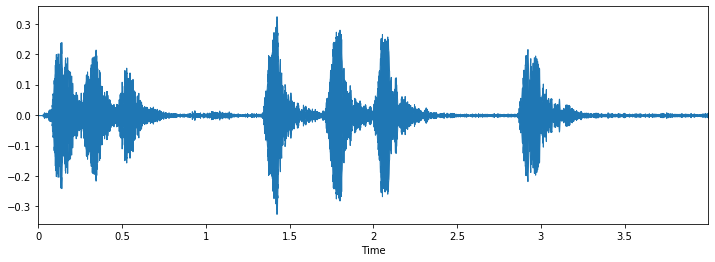

In [42]:
#audio of a dog bark
name = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/7383-3-0-0.wav'
plt.figure(figsize=(12,4))
d,sam_rate = librosa.load(name)
_ = librosa.display.waveplot(d,sr=sam_rate)
ipd.Audio(name)

Sample data weighted towards car crash - peak in the dog bark sample is similar in shape to the car crash sample

In [43]:
name1 = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/AAAGH1.wav'
print_prediction(name1) 

The predicted class is: yelp 

car_crash 		 :  0.00000000000000000016085299907978
doorscrm 		 :  0.00000000000158637588742321922197
dummy 		 :  0.00000000000000000013144875748096
new 		 :  0.00000000000000000004257792326551
yelp 		 :  1.00000000000000000000000000000000


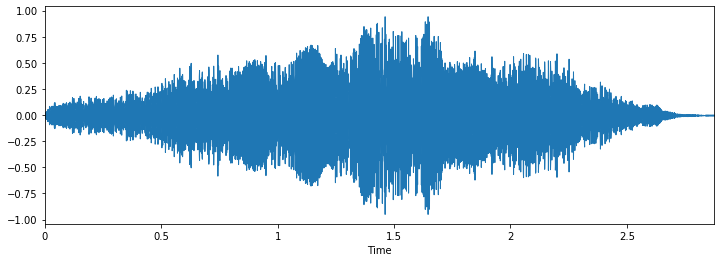

In [44]:
#audio of a man shouting
name1 = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/AAAGH1.wav'
plt.figure(figsize=(12,4))
d1,sam_rate1 = librosa.load(name1)
_ = librosa.display.waveplot(d1,sr=sam_rate1)
ipd.Audio(name1)

Sample data weighted towards yelp - peak in the shout sample is similar in shape to the yelp sample

In [45]:
name2 = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/Car Loosing Control.wav'
print_prediction(name2) 

The predicted class is: car_crash 

car_crash 		 :  1.00000000000000000000000000000000
doorscrm 		 :  0.00000000000000145142695402050194
dummy 		 :  0.00000000000002012000727700039016
new 		 :  0.00000000000007562771616636057570
yelp 		 :  0.00000000000046969177679156981497


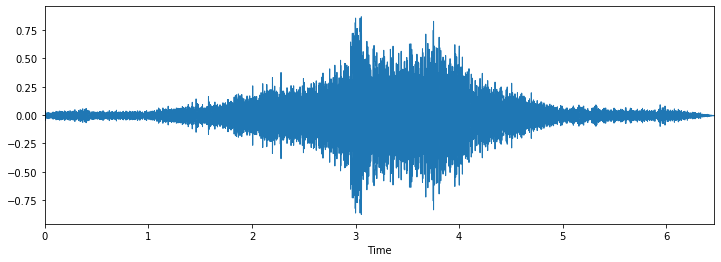

In [46]:
#audio of car loosing control
name2 = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/Car Loosing Control.wav'
plt.figure(figsize=(12,4))
d2,sam_rate2 = librosa.load(name2)
_ = librosa.display.waveplot(d2,sr=sam_rate2)
ipd.Audio(name2)

In [47]:
name3 = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/drilling_1.wav'
print_prediction(name3)

The predicted class is: car_crash 

car_crash 		 :  1.00000000000000000000000000000000
doorscrm 		 :  0.00000000000000000000000000000010
dummy 		 :  0.00000000000000000000000000002354
new 		 :  0.00000000000000000000000000028191
yelp 		 :  0.00000000000000000000000000000052


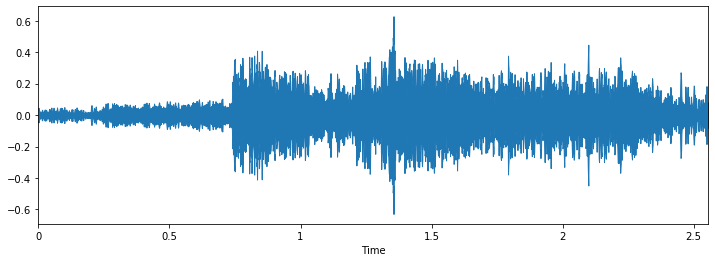

In [48]:
name3 = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/drilling_1.wav'
plt.figure(figsize=(12,4))
d3,sam_rate3 = librosa.load(name3)
_ = librosa.display.waveplot(d3,sr=sam_rate3)
ipd.Audio(name3)

Sample data weighted towards car crash - peak in the drilling sample is similar in shape to the car crash sample

In [49]:
#audio of gun shot
name4 = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/gun_shot_1.wav'
print_prediction(name4)

The predicted class is: car_crash 

car_crash 		 :  1.00000000000000000000000000000000
doorscrm 		 :  0.00000000000000000000000000000000
dummy 		 :  0.00000000000000000000000000000000
new 		 :  0.00000000000000000000000000000000
yelp 		 :  0.00000000000000000000000000000002


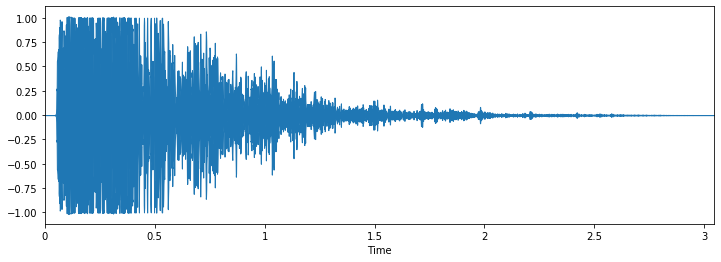

In [50]:
name4 = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/gun_shot_1.wav'
plt.figure(figsize=(12,4))
d4,sam_rate4 = librosa.load(name4)
_ = librosa.display.waveplot(d4,sr=sam_rate4)
ipd.Audio(name4)

Sample data weighted towards car crash - peak in the gun shot sample is similar in shape to the car crash sample

In [51]:
#audio of creaking sound
name5 = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/lidcreak.wav'
print_prediction(name5)

The predicted class is: yelp 

car_crash 		 :  0.03331265226006507873535156250000
doorscrm 		 :  0.00000599833265368943102657794952
dummy 		 :  0.00000654730592941632494330406189
new 		 :  0.00003386907701496966183185577393
yelp 		 :  0.96664094924926757812500000000000


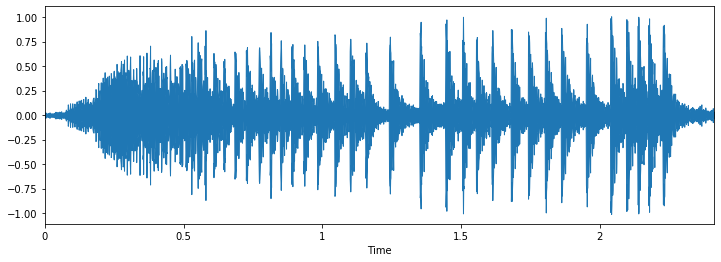

In [52]:
name5 = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/lidcreak.wav'
plt.figure(figsize=(12,4))
d5,sam_rate5 = librosa.load(name5)
_ = librosa.display.waveplot(d5,sr=sam_rate5)
ipd.Audio(name5)

Sample data weighted towards yelp - peak in the creak sample is similar in shape to the yelp sample

In [54]:
#audio of man shouting
name6 = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/maleyell.wav'
print_prediction(name6)

The predicted class is: doorscrm 

car_crash 		 :  0.00000000000000003393137224339882
doorscrm 		 :  1.00000000000000000000000000000000
dummy 		 :  0.00000000000000000007436883619432
new 		 :  0.00000000000000000207205476081114
yelp 		 :  0.00000000000003263028749652709115


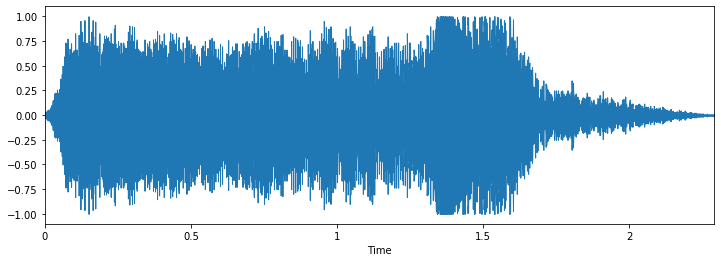

In [55]:
name6 = r'C:/Users/nikita.ramesh.rao/Desktop/test/testing_audios/maleyell.wav'
plt.figure(figsize=(12,4))
d6,sam_rate6 = librosa.load(name6)
_ = librosa.display.waveplot(d6,sr=sam_rate6)
ipd.Audio(name6)

Sample data weighted towards doorscrm - peak in the shout sample is similar in shape to the doorscrm sample

## End results
As observed the model is predicting well for other audios as well. Since dataset had only 3277 files for training and only 